In [14]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import seaborn as sns

In [15]:
# --- Call file --- #
report = pd.read_excel('delta_sys_cost.xlsx')
# ----------------- #

graph_data = pd.DataFrame(pd.pivot_table(data = report, columns = 'cost_cat', index = 'scenario', values = 'Discounted Cost (Bil $)', aggfunc = 'sum', fill_value = 0))
x_scens = report['scenario'].unique()
graph_data = graph_data.reindex(index=x_scens)
graph_data.reset_index(inplace=True)

# Create data frame for % change
pct_data = pd.DataFrame(pd.pivot_table(data=report, columns='scenario', values=['Net Level Discounted Cost (Bil $)','Base Cost (Bil $)']))
pct_data = pd.pivot_table(data=pct_data, columns=['Base Cost (Bil $)','Net Level Discounted Cost (Bil $)'])
pct_data = pct_data.reindex(index=x_scens)
pct_data.reset_index(inplace=True)
pct_data['% Net Change'] = [pct_data['Net Level Discounted Cost (Bil $)'][i]/pct_data['Base Cost (Bil $)'][i] for i in range(len(pct_data.index))]
pct_data['% Net Change'] = pct_data['% Net Change'].map('{:.2%}'.format)
# ---------------------------------------- #

# Get cost category colors 
cost_cat_styles = pd.read_csv('cost_cat_style.csv')
cost_cat_styles = cost_cat_styles.loc[cost_cat_styles.order.isin(graph_data.columns.tolist())]
# Rearrange data to teh same order as teh cost categories
graph_data = graph_data[cost_cat_styles.order.tolist()]
pct_data

,scenario,Base Cost (Bil $),Net Level Discounted Cost (Bil $),% Net Change
0,BAU,5457.428050,49.872458,0.91%
1,Decarb,6222.030944,-4.863217,-0.08%
2,Low RE Costs,5767.118953,-9.789286,-0.17%
3,High RE Costs,6741.018099,-8.597365,-0.13%
4,Reduced RE,6534.715786,-11.059514,-0.17%
5,No CCS,6944.534894,-170.375942,-2.45%
6,Low FC Costs,6222.030944,-3.637637,-0.06%
7,High FC Costs,6222.030944,-6.859430,-0.11%
8,High Electrification,7212.794245,-153.783577,-2.13%


In [5]:
graph_data

cost_cat,PTC,ITC,CCS Incentives,Gen & Stor Capex,Gen & Stor O&M,Fuel,Transmission Capex,Transmission O&M,Interconnection Capex,Interconnection O&M,CO2 T&S Capex,H2 Prod Capex,H2 Prod O&M,ACP
0,-1.874343,8.236290,0.156841,-34.545237,17.369003,46.058828,-3.572394,-0.854821,-3.776734,-0.704326,-0.105076,6.476157,17.040726,-0.032456
1,-0.968681,18.124132,-8.295651,-68.496005,0.807060,29.785096,-6.890531,-2.015963,3.353783,0.677826,2.930353,15.685796,10.439567,0.000000
2,-1.364954,11.153267,0.842923,-57.169948,-1.269925,26.502053,-9.898867,-2.940365,1.280802,0.187996,-0.638589,14.593348,8.932970,0.000000
3,1.741390,22.194448,-7.953201,-76.862588,3.624121,22.391042,3.072739,1.201574,-3.486335,-0.580947,3.970235,9.792197,12.297961,0.000000
4,3.250272,11.831276,-9.106453,-60.869430,2.859681,28.362446,-7.599098,-2.229814,-4.767541,-0.993816,4.992097,11.539343,10.694821,0.976702
5,11.089457,40.441503,0.000000,-107.769059,-29.568371,-52.788598,-14.691939,-5.127401,-7.709009,-1.171657,0.000000,-8.515067,5.434199,0.000000
6,-0.475530,21.493711,-9.448704,-83.841715,1.475073,38.291573,-7.265911,-2.130910,3.120585,0.652918,3.269319,19.298786,11.923169,0.000000
7,-1.234021,11.508119,-8.086456,-43.161021,1.915012,19.755228,-6.937112,-2.183307,1.074254,0.186748,2.780053,10.135685,7.387388,0.000000
8,30.206534,-3.539237,-3.091037,-73.142879,-0.597588,-23.838362,-53.331772,-16.726401,-23.056789,-4.285435,2.682946,-1.878831,16.815273,0.000000


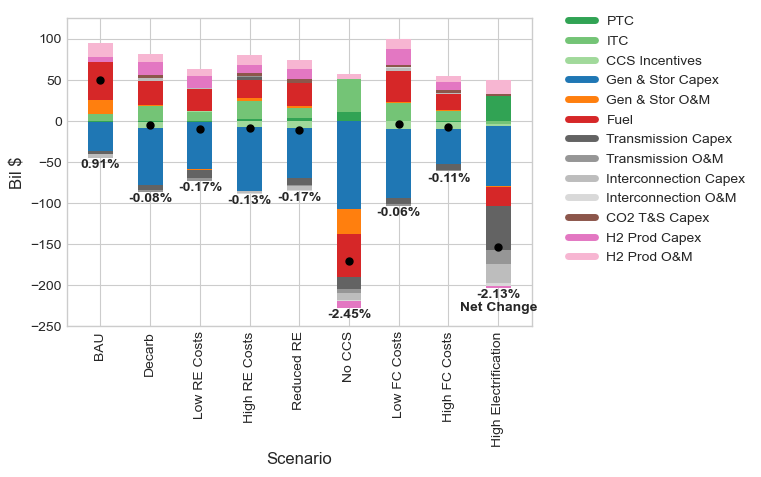

In [16]:
# Get cost category list
y_categories = cost_cat_styles.order.tolist()

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True,) # , layout = 'constrained'

# Create lists to keep track of stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Create a list to track cost categories with negligible values
cost_cat_sums = [0]*len(y_categories)

# Loop through all cost categories
for t in range(len(y_categories)):
    yvals = graph_data[y_categories[t]].tolist()
    cost_cat_sums[t] = sum([abs(val) for val in yvals])
    bottoms = []
    # Update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot bars of teh current cost category at each scenarios
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = cost_cat_styles.color.tolist()[t])



# Add % change to the bottom of each scenario's stacked bar
for b in range(len(x_scens)):
    axs.text(x_scens[b],                    # x-position, align with scenarios
             running_sums_neg[b]-12,        # y-position, might need to adjust the number
             pct_data['% Net Change'][b],   # value
             ha='center',weight='bold', fontsize=10) # styling

# Add label for % net change
axs.text(x_scens[b], running_sums_neg[b]-28, 'Net Change', ha='center',weight='bold', fontsize=10)
# Add dots to indicate net change values
axs.scatter(x_scens,pct_data['Net Level Discounted Cost (Bil $)'], c='black', marker='o',s=25, label='Net Change Value')

# Customize plot
axs.set_ylabel('Bil $', fontsize=12)
axs.set_xlabel('Scenario', fontsize=12)
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)
axs.set_ylim(-250, 125)

# Drop cost categories with negligible changes
keep_cost_cat = []
for t in range(len(cost_cat_sums)):
    if abs(cost_cat_sums[t]) > 5:
        keep_cost_cat.append(y_categories[t])

# Customize legend
cost_cat_legend = cost_cat_styles.loc[cost_cat_styles.order.isin(keep_cost_cat)]
custom_lines = [Line2D([0], [0], color=x, lw=5) for x in cost_cat_legend.color.tolist()]
axs.legend(custom_lines, cost_cat_legend.order.tolist() ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 10)

Plot delta system cost vs. Decarb (FC)

In [6]:
# --- Call file --- #
report = pd.read_excel('delta_sys_cost_all_fc.xlsx')
# ----------------- #

graph_data = pd.DataFrame(pd.pivot_table(data = report, columns = 'cost_cat', index = 'scenario', values = 'Discounted Cost (Bil $)', aggfunc = 'sum', fill_value = 0))
x_scens = report['scenario'].unique()
graph_data = graph_data.reindex(index=x_scens)
graph_data.reset_index(inplace=True)
graph_data


cost_cat,scenario,ACP,CCS Incentives,CO2 T&S Capex,Fuel,Gen & Stor Capex,Gen & Stor O&M,H2 Prod Capex,H2 Prod O&M,ITC,Interconnection Capex,Interconnection O&M,PTC,Transmission Capex,Transmission O&M
0,BAU (FC),0.072686,75.342909,-32.546378,-23.804117,-475.333594,-117.581098,-36.721034,2.024250,39.730356,-68.080199,-11.186387,35.205028,-71.027784,-25.961858
1,Low RE Costs (FC),0.000000,32.907445,-12.042570,-75.834623,-208.660129,-140.391819,-10.769172,-2.640099,18.260573,4.233552,-0.837914,-47.042685,-14.264584,-2.756034
2,High RE Costs (FC),0.000000,-56.899311,19.809883,101.711713,296.806353,111.148980,15.201617,1.724453,-28.745702,-13.501901,-1.584660,44.353824,20.244706,4.983052
3,Reduced RE (FC),3.351302,-66.793825,24.730766,54.852876,94.992178,16.576076,-3.070782,0.345331,-41.539224,93.862177,24.414446,46.974050,41.682322,16.110852
4,No CCS (FC),0.000000,79.484569,-34.115415,22.467072,326.060605,11.347080,143.259399,13.241843,-62.423889,94.706945,15.089055,-112.860541,42.016172,18.718331
5,Low FC Costs (FC),0.000000,-1.153053,0.338966,8.506477,-15.345710,0.668012,3.612990,1.483602,3.369579,-0.233198,-0.024908,0.493151,-0.375380,-0.114948
6,High FC Costs (FC),0.000000,0.209195,-0.150301,-10.029867,25.334984,1.107952,-5.550110,-3.052179,-6.616014,-2.279528,-0.491078,-0.265340,-0.046582,-0.167344
7,High Electrification (FC),0.000000,9.343876,-1.865190,80.699433,406.576238,187.611916,43.894343,11.621745,-17.253593,150.546485,23.996795,-202.918556,103.597811,45.991639


In [7]:
pct_data = pd.DataFrame(pd.pivot_table(data=report, columns='scenario', values=['Net Level Discounted Cost (Bil $)','Base Cost (Bil $)']))
pct_data = pd.pivot_table(data=pct_data, columns=['Base Cost (Bil $)','Net Level Discounted Cost (Bil $)'])
pct_data = pct_data.reindex(index=x_scens)
pct_data.reset_index(inplace=True)
pct_data['% Net Change'] = [pct_data['Net Level Discounted Cost (Bil $)'][i]/pct_data['Base Cost (Bil $)'][i] for i in range(len(pct_data.index))]
pct_data['% Net Change'] = pct_data['% Net Change'].map('{:.2%}'.format)
# ---------------------------------------- #


cost_cat_styles = pd.read_csv('cost_cat_style.csv')
cost_cat_styles = cost_cat_styles.loc[cost_cat_styles.order.isin(graph_data.columns.tolist())]
graph_data = graph_data[cost_cat_styles.order.tolist()]
pct_data

,scenario,Base Cost (Bil $),Net Level Discounted Cost (Bil $),% Net Change
0,BAU (FC),6217.167727,-709.867219,-11.42%
1,Low RE Costs (FC),6217.167727,-459.838059,-7.40%
2,High RE Costs (FC),6217.167727,515.253008,8.29%
3,Reduced RE (FC),6217.167727,306.488546,4.93%
4,No CCS (FC),6217.167727,556.991225,8.96%
5,Low FC Costs (FC),6217.167727,1.225581,0.02%
6,High FC Costs (FC),6217.167727,-1.996212,-0.03%
7,High Electrification (FC),6217.167727,841.842941,13.54%


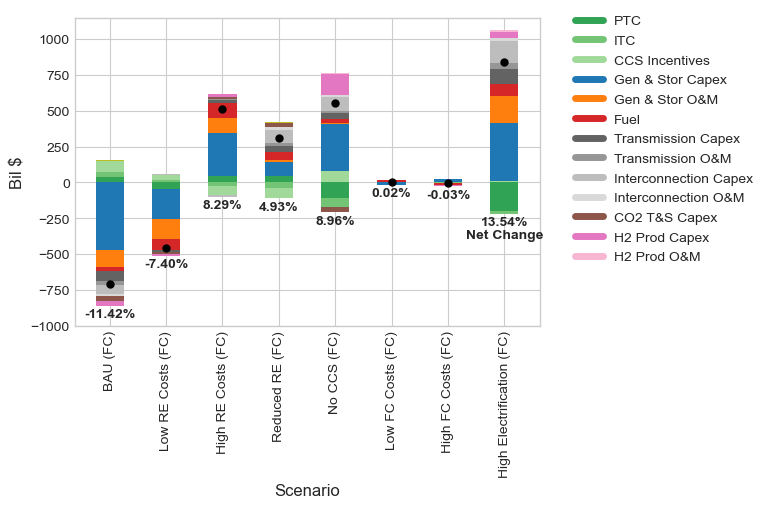

In [22]:
y_categories = cost_cat_styles.order.tolist()

running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True,) # , layout = 'constrained'

#running_sums = [0]*len(yvals)
cost_cat_sums = [0]*len(y_categories)
for t in range(len(y_categories)):
    yvals = graph_data[y_categories[t]].tolist()
    cost_cat_sums[t] = sum([abs(val) for val in yvals])
    bottoms = []
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = cost_cat_styles.color.tolist()[t])
    #running_sums = [running_sums[i] + yvals[i] for i in range(len(yvals))]
axs.set_ylabel('Bil $', fontsize=12)
axs.set_xlabel('Scenario', fontsize=12)
axs.set_ylim(-1000,1150)
for b in range(len(x_scens)):
    axs.text(x_scens[b], running_sums_neg[b]-80, pct_data['% Net Change'][b], ha='center',weight='bold', fontsize=10)
axs.text(x_scens[b], running_sums_neg[b]-170, 'Net Change', ha='center',weight='bold', fontsize=10)
axs.scatter(x_scens,pct_data['Net Level Discounted Cost (Bil $)'], c='black', marker='o',s=25, label='Net Change Value')
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)

keep_cost_cat = []
for t in range(len(cost_cat_sums)):
    if abs(cost_cat_sums[t]) > 10:
        keep_cost_cat.append(y_categories[t])
cost_cat_legend = cost_cat_styles.loc[cost_cat_styles.order.isin(keep_cost_cat)]
custom_lines = [Line2D([0], [0], color=x, lw=5) for x in cost_cat_legend.color.tolist()]
axs.legend(custom_lines, cost_cat_legend.order.tolist() ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 10)